In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing, pipeline
from sklearn.ensemble import RandomForestRegressor
import psycopg2
from sqlalchemy import create_engine
from pins import board_rsconnect
from dotenv import load_dotenv
import os
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
load_dotenv()

True

In [2]:
board = board_rsconnect(
    server_url="https://colorado.rstudio.com/rsc/",
    api_key=os.getenv("CONNECT_API_KEY")
)
#> Connecting to RSC 1.9.0.1 at <https://connect.rstudioservices.com>

In [3]:
df = board.pin_read(name="xu.fei/bike-all-dates-05042022")

In [4]:
df.shape

(12260589, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12260589 entries, 0 to 12260588
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   id       int64  
 1   hour     int64  
 2   date     object 
 3   month    int64  
 4   dow      object 
 5   n_bikes  float64
 6   lat      float64
 7   lon      float64
dtypes: float64(3), int64(3), object(2)
memory usage: 748.3+ MB


In [6]:
df.date = pd.to_datetime(df.date)

In [7]:
df.columns = ['id', 'hour', 'date', 'month', 'dow', 'n_bikes', 'lat', 'lon']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12260589 entries, 0 to 12260588
Data columns (total 8 columns):
 #   Column   Dtype         
---  ------   -----         
 0   id       int64         
 1   hour     int64         
 2   date     datetime64[ns]
 3   month    int64         
 4   dow      object        
 5   n_bikes  float64       
 6   lat      float64       
 7   lon      float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 748.3+ MB


In [9]:
df.date.max()

Timestamp('2022-05-04 00:00:00')

In [10]:
N_DAYS_AGO = 15

In [11]:
date_N_days_ago = df.date.max() - timedelta(days=N_DAYS_AGO)

In [12]:
date_N_days_ago

Timestamp('2022-04-19 00:00:00')

In [13]:
df_train = df.loc[df.date < date_N_days_ago]
df_train.shape

(12046866, 8)

In [14]:
df_test = df.loc[df.date >= date_N_days_ago]
df_test.shape

(213723, 8)

In [15]:
df_train_6m = df_train.iloc[:int(6e6), :]

In [16]:
del df_train, df

In [17]:
df_train_6m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000000 entries, 0 to 6105947
Data columns (total 8 columns):
 #   Column   Dtype         
---  ------   -----         
 0   id       int64         
 1   hour     int64         
 2   date     datetime64[ns]
 3   month    int64         
 4   dow      object        
 5   n_bikes  float64       
 6   lat      float64       
 7   lon      float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 412.0+ MB


In [18]:
def get_features(df: pd.DataFrame, label: str=None) -> pd.DataFrame:
    """
    Get time series features from dataframe
    """
    ds = df['date'].dt
    df['dayofweek'] = ds.dayofweek
    df['quarter'] = ds.quarter
    df['month'] = ds.month
    df['year'] = ds.year
    df['dayofyear'] = ds.dayofyear
    df['dayofmonth'] = ds.day
    df['weekofyear'] = ds.isocalendar().week.astype(int)
    X = df[[
        'hour','dayofweek','quarter','month','year',
        'dayofyear','dayofmonth','weekofyear','lat','lon'
    ]]
    if label:
        y = df[label]
        return X, y
    return X

In [19]:
X_train, y_train = get_features(df_train_6m, label='n_bikes')

In [20]:
X_test, y_test = get_features(df_test, label='n_bikes')

In [21]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213723 entries, 190 to 12259911
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   hour        213723 non-null  int64  
 1   dayofweek   213723 non-null  int64  
 2   quarter     213723 non-null  int64  
 3   month       213723 non-null  int64  
 4   year        213723 non-null  int64  
 5   dayofyear   213723 non-null  int64  
 6   dayofmonth  213723 non-null  int64  
 7   weekofyear  213723 non-null  int64  
 8   lat         213723 non-null  float64
 9   lon         213723 non-null  float64
dtypes: float64(2), int64(8)
memory usage: 17.9 MB


In [22]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=True) 

/usr/home/xu.fei/bike_predict_python/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:7.37005	validation_1-rmse:6.48298
[1]	validation_0-rmse:6.32266	validation_1-rmse:5.61160
[2]	validation_0-rmse:5.70795	validation_1-rmse:5.21635
[3]	validation_0-rmse:5.35006	validation_1-rmse:4.99361
[4]	validation_0-rmse:5.11964	validation_1-rmse:4.90110
[5]	validation_0-rmse:4.97557	validation_1-rmse:4.83994
[6]	validation_0-rmse:4.88935	validation_1-rmse:4.82101
[7]	validation_0-rmse:4.83465	validation_1-rmse:4.79039
[8]	validation_0-rmse:4.79338	validation_1-rmse:4.78461
[9]	validation_0-rmse:4.76217	validation_1-rmse:4.78001
[10]	validation_0-rmse:4.73402	validation_1-rmse:4.78176
[11]	validation_0-rmse:4.70664	validation_1-rmse:4.76813
[12]	validation_0-rmse:4.66219	validation_1-rmse:4.73099
[13]	validation_0-rmse:4.65420	validation_1-rmse:4.73513
[14]	validation_0-rmse:4.63673	validation_1-rmse:4.73199
[15]	validation_0-rmse:4.62376	validation_1-rmse:4.73848
[16]	validation_0-rmse:4.61247	validation_1-rmse:4.74117
[17]	validation_0-rmse:4.59319	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [23]:
plt.style.use('fivethirtyeight')

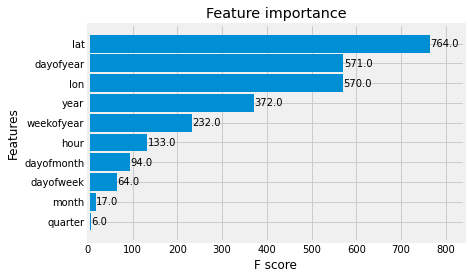

In [24]:
_ = plot_importance(reg, height=0.9)

In [25]:
df_test['bike_pred'] = reg.predict(X_test)

In [26]:
import math
from math import sqrt
test_mse = mean_squared_error(y_test, df_test['bike_pred'])
rmse = sqrt(test_mse)
print('RMSE: %f' % rmse)

RMSE: 4.660859


In [27]:
np.mean(y_test)

6.396835701663679

In [28]:
df_test.head()

,id,hour,date,month,dow,n_bikes,lat,lon,dayofweek,quarter,year,dayofyear,dayofmonth,weekofyear,bike_pred
190,73,4,2022-04-19,4,Tuesday,0.0,38.933668,-76.991016,1,2,2022,109,19,16,2.676972
191,73,4,2022-04-20,4,Wednesday,1.0,38.933668,-76.991016,2,2,2022,110,20,16,2.676972
192,73,4,2022-04-21,4,Thursday,0.0,38.933668,-76.991016,3,2,2022,111,21,16,2.676972
193,73,4,2022-04-22,4,Friday,0.0,38.933668,-76.991016,4,2,2022,112,22,16,2.676972
194,73,4,2022-04-23,4,Saturday,3.0,38.933668,-76.991016,5,2,2022,113,23,16,2.614131


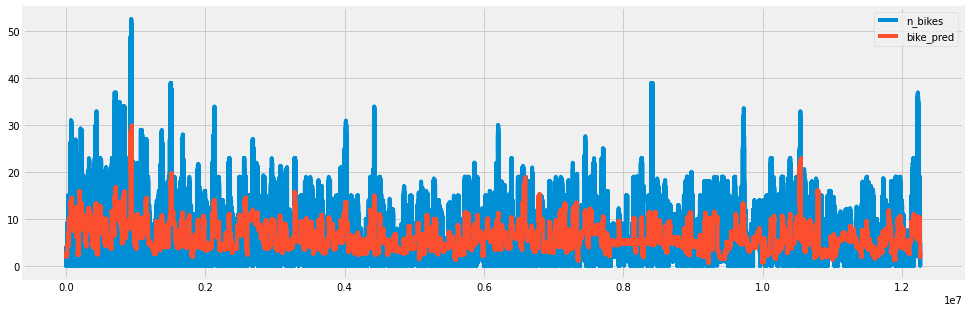

In [29]:
_ = df_test[['n_bikes','bike_pred']].plot(figsize=(15, 5))

In [30]:
df_all = pd.concat([df_test, df_train_6m], sort=False)

In [31]:
mean_squared_error(y_true=df_test['n_bikes'],
                   y_pred=df_test['bike_pred'])

21.723608676004737

In [32]:
mean_absolute_error(y_true=df_test['n_bikes'],
                   y_pred=df_test['bike_pred'])

3.640628322329985

# Save model and write to pins

In [39]:
import joblib
joblib.dump(reg, "bike_xgboost.joblib") 

['bike_xgboost.joblib']

In [43]:
board.pin_write(
    reg,
    name="xu.fei/bike_xgboost_6m",
    title='Pinned xgboost model for bike share',
    type="joblib",
    description = "Test xgboost model trained with bike share data",
)

Writing to pin 'xu.fei/bike_xgboost_6m'


Meta(title='Pinned xgboost model for bike share', description='Test xgboost model trained with bike share data', created='20220510T011519Z', pin_hash='d46cb203ca28c896', file='bike_xgboost_6m.joblib', file_size=228292, type='joblib', api_version=1, version=VersionRaw(version='56177'), name='xu.fei/bike_xgboost_6m', user={})

# Vetiver

In [33]:
from vetiver import VetiverModel, VetiverAPI, vetiver_endpoint

In [34]:
v = VetiverModel(reg, save_ptype = True, ptype_data=df_train_6m, model_name = "bikeshare_xgboost")

In [35]:
from rsconnect.api import RSConnectServer
from rsconnect.actions import deploy_python_fastapi

In [36]:
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [37]:
rsc_url = os.getenv("CONNECT_SERVER")
api_key = os.getenv("CONNECT_API_KEY")
connect_server = RSConnectServer(url=rsc_url, api_key=api_key)

In [45]:
deploy_python_fastapi?

Signature:
deploy_python_fastapi(
    connect_server,
    directory,
    extra_files,
    excludes,
    entry_point,
    new=False,
    app_id=None,
    title=None,
    python=None,
    conda_mode=False,
    force_generate=False,
    log_callback=None,
)
Docstring:
A function to deploy a Python ASGI API module to RStudio Connect.  Depending on the files involved
    and network latency, this may take a bit of time.

    :param connect_server: the Connect server information.
    :param directory: the app directory to deploy.
    :param extra_files: any extra files that should be included in the deploy.
    :param excludes: a sequence of glob patterns that will exclude matched files.
    :param entry_point: the module/executable object for the WSGi framework.
    :param new: a flag to force this as a new deploy.
    :param app_id: the ID of an existing application to deploy new files for.
    :param title: an optional title for the deploy.  If this is not provided, ne will
    be generat

In [46]:
deploy_python_fastapi(
    connect_server = connect_server,
    title = "Xgboost model for bike share",
    directory = "../",
    extra_files = None,
    entry_point = "model:api",
    excludes = None,
)

('https://colorado.rstudio.com/rsc/connect/#/apps/f61c7722-1b41-4cb1-ac55-a67e6d226925',
 ['Building FastAPI application...',
  'Bundle created with Python version 3.9.6 is compatible with environment Kubernetes::ghcr.io/rstudio/content-pro:r4.0.5-py3.9.2-bionic with Python version 3.9.2 from /opt/python/3.9.2/bin/python3.9 ',
  'Bundle requested Python version 3.9.6; using /opt/python/3.9.2/bin/python3.9 from Kubernetes::ghcr.io/rstudio/content-pro:r4.0.5-py3.9.2-bionic which has version 3.9.2',
  'Determining session server location ...',
  'Connecting to session server http://172.19.57.196:30414 ...',
  'Connected to session server http://172.19.57.196:30414',
  '2022/05/10 01:30:14.312393560 Running on host: python-environment-restore-mvlxc-hxjwm',
  '2022/05/10 01:30:14.312413062 Working directory: /opt/rstudio-connect/mnt/app',
  '2022/05/10 01:30:14.312481936 Environment will be built with Python "3.9.2 (default, Mar  3 2021, 20:02:32)  [GCC 7.3.0]" at /opt/python/3.9.2/bin/pyth

In [48]:
# Using make_column_transformer to One-Hot Encode
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [49]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['dow']),
    remainder='passthrough')

In [76]:
transformer.get_feature_names()

/usr/home/xu.fei/bike_predict_python/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['onehotencoder__x0_Friday',
 'onehotencoder__x0_Monday',
 'onehotencoder__x0_Saturday',
 'onehotencoder__x0_Sunday',
 'onehotencoder__x0_Thursday',
 'onehotencoder__x0_Tuesday',
 'onehotencoder__x0_Wednesday',
 'id',
 'hour',
 'date',
 'month',
 'n_bikes',
 'lat',
 'lon']

In [51]:
transformed_test = transformer.fit_transform(df_test)
transformed_df_test = pd.DataFrame(
    transformed_test, 
    columns=transformer.get_feature_names_out()
)

In [52]:
transformed_train_6m = transformer.fit_transform(df_train_6m)
transformed_df_train_6m = pd.DataFrame(
    transformed_train_6m, 
    columns=transformer.get_feature_names_out()
)

In [53]:
transformed_df_train_6m.shape

(6000000, 14)

In [54]:
transformed_df_train_6m.columns

Index(['onehotencoder__dow_Friday', 'onehotencoder__dow_Monday',
       'onehotencoder__dow_Saturday', 'onehotencoder__dow_Sunday',
       'onehotencoder__dow_Thursday', 'onehotencoder__dow_Tuesday',
       'onehotencoder__dow_Wednesday', 'remainder__id', 'remainder__hour',
       'remainder__date', 'remainder__month', 'remainder__n_bikes',
       'remainder__lat', 'remainder__lon'],
      dtype='object')

In [57]:
transformed_df_test.head()

,onehotencoder__dow_Friday,onehotencoder__dow_Monday,onehotencoder__dow_Saturday,onehotencoder__dow_Sunday,onehotencoder__dow_Thursday,onehotencoder__dow_Tuesday,onehotencoder__dow_Wednesday,remainder__id,remainder__hour,remainder__date,remainder__month,remainder__n_bikes,remainder__lat,remainder__lon
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,73,4,2022-04-19,4,0.0,38.933668,-76.991016
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,73,4,2022-04-20,4,1.0,38.933668,-76.991016
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,73,4,2022-04-21,4,0.0,38.933668,-76.991016
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,73,4,2022-04-22,4,0.0,38.933668,-76.991016
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,73,4,2022-04-23,4,3.0,38.933668,-76.991016


In [90]:
del transformed_df_train_6m, transformed_df_test

In [92]:
del transformed_train_6m, transformed_test